In [3]:
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from PIL import Image
from keras.layers import Layer

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
DIR_MODEL = 'models/resnet50v2_f_no_freeze.h5'
# LayerScale
class LayerScale(Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        init_values (float): value to initialize the diagonal matrix of LayerScale.
        projection_dim (int): projection dimension used in LayerScale.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma
    
model = keras.models.load_model(DIR_MODEL)#, custom_objects={'LayerScale': LayerScale})

In [ ]:
# Show all layers idented
model.summary(expand_nested=True)

1/1 [==============================] - 1s 553ms/step


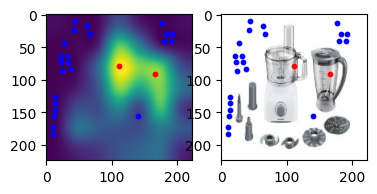

In [7]:
from PIL import Image as Img
from sklearn.cluster import KMeans

clases = os.listdir('Final_dataset_small/Train')

img_path = r'Final_dataset_small\Train\RAEE\procesador-de-alimentos-multifuncional-600w-regular.jpg'.replace('\\', '/')

img_array = keras.preprocessing.image.img_to_array(
    keras.preprocessing.image.load_img(img_path, target_size=(224, 224)),
)

# Make model
img_array = tf.expand_dims(img_array/255.0, 0)  # Create batch axis

model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

#model.layers[-1].activation = tf.keras.activations.softmax

#Paliative fix

#Make GradCAM heatmap following the Keras tutorial.
last_conv_layer = model.layers[-4].layers[-1]
last_conv_layer_model = keras.Model(model.layers[-4].inputs, last_conv_layer.output)

# Second, we create a model that maps the activations of the last conv
# layer to the final class predictions
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer in model.layers[-3:]:
    x = layer(x)
classifier_model = keras.Model(classifier_input, x)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape(persistent=True) as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

    first_order_grads = tape.gradient(top_class_channel, last_conv_layer_output)
    second_order_grads = tape.gradient(first_order_grads, last_conv_layer_output)

    # Compute the Grad-CAM++ weights
    alpha = np.sum(second_order_grads, axis=(0, 1, 2), keepdims=True)
    beta = np.sum(first_order_grads, axis=(0, 1, 2), keepdims=True)
    weights = np.divide(first_order_grads - 0.5 * alpha * second_order_grads, beta, where=beta != 0)
    

# Create the Grad-CAM++ heatmap
last_conv_layer_output = last_conv_layer_output.numpy()[0]

#for i in range(last_conv_layer_output.shape[-1]):
#    last_conv_layer_output[:, :, i] *= weights[0, :, :, i]

heatmap = np.mean(last_conv_layer_output, axis=-1)

heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
heatmap = np.uint8(255 * heatmap)

heatmap = np.array(Img.fromarray(heatmap).convert('L').resize(img_array.shape[1:3]))


from skimage.feature import peak_local_max

peaks_max = peak_local_max(heatmap, min_distance=10, threshold_rel=0.5)

peaks_min = peak_local_max(255 - heatmap, min_distance=10, threshold_rel=0.5)

# Show peaks
plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.scatter(peaks_max[:, 1], peaks_max[:, 0], c='r', s=10)
plt.scatter(peaks_min[:, 1], peaks_min[:, 0], c='b', s=10)

# Show image
plt.subplot(1, 3, 3)
plt.imshow(img_array[0])
plt.scatter(peaks_max[:, 1], peaks_max[:, 0], c='r', s=10)
plt.scatter(peaks_min[:, 1], peaks_min[:, 0], c='b', s=10)
plt.show()

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

image = cv2.imread(r'Final_dataset_small\Train\RAEE\procesador-de-alimentos-multifuncional-600w-regular.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to("cuda")

predictor = SamPredictor(sam)
print('Now predicting...')

# Change x and y
peaks_min_ = peaks_max.copy()
peaks_min_[:, 0], peaks_min_[:, 1] = peaks_min_[:, 1], peaks_min_[:, 0].copy()

predictor.set_image(image)
masks, _, _ = predictor.predict(point_coords=peaks_min_, point_labels=np.ones(peaks_min_.shape[0]), multimask_output=True,)

Now predicting...


In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

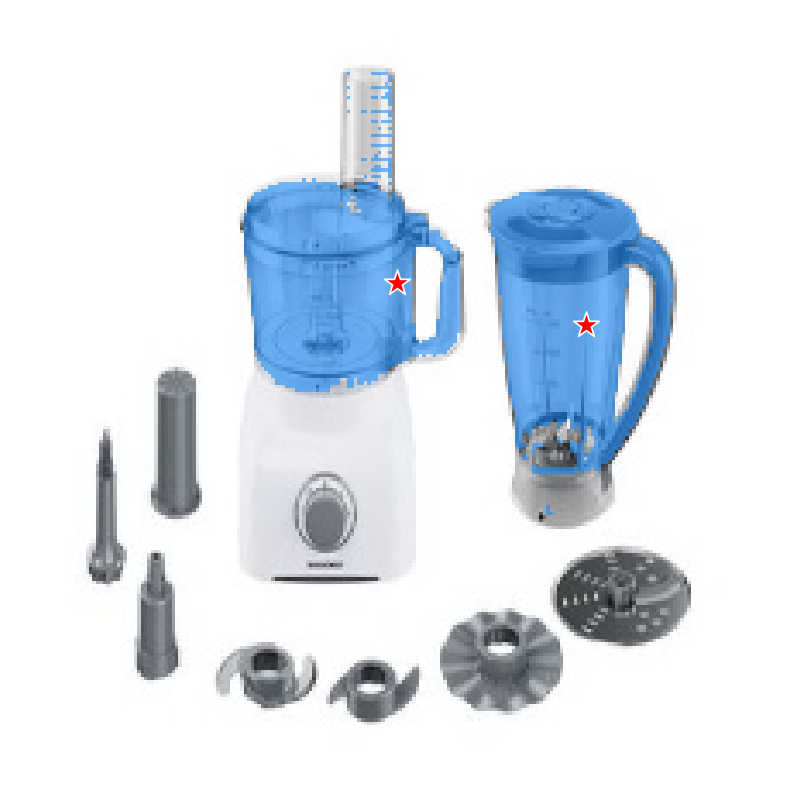

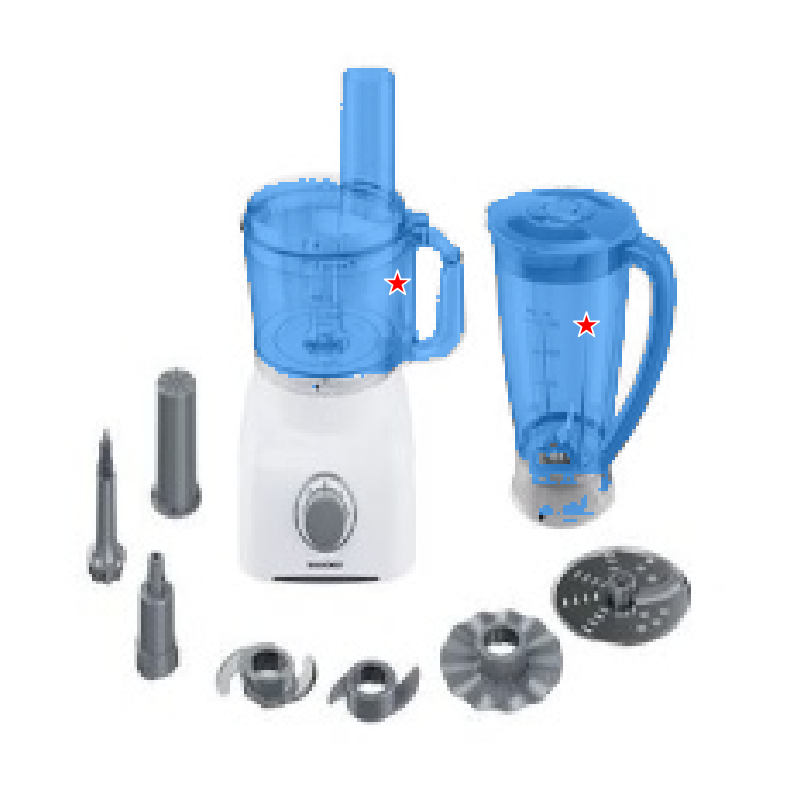

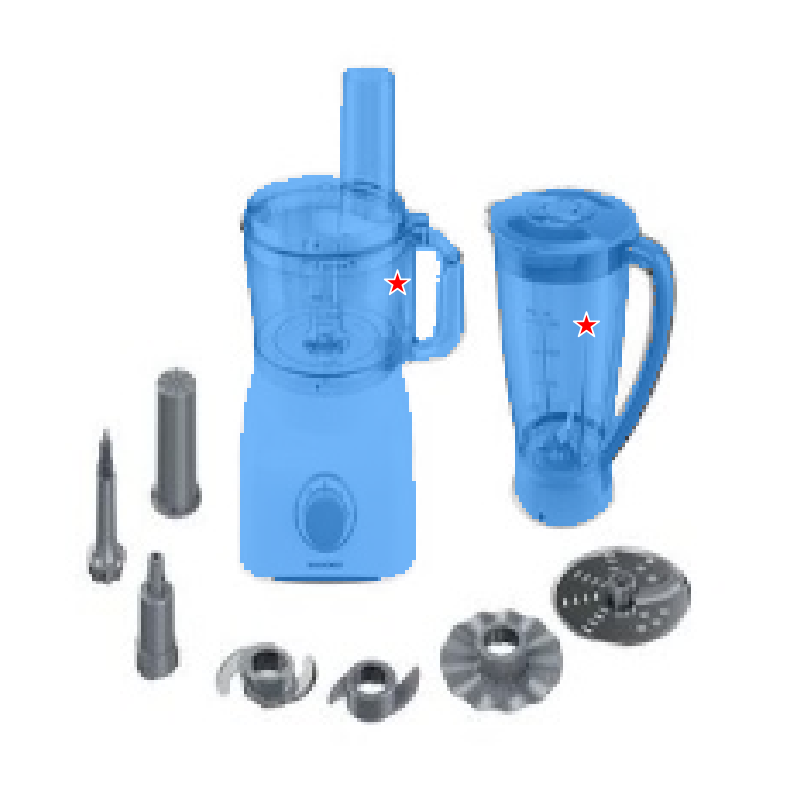

In [13]:
for i, mask in enumerate(masks):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(peaks_min_, np.zeros(peaks_min_.shape[0]), plt.gca())
    plt.axis('off')
    plt.show()  

In [ ]:
def compute_occlusion_map(model, img, occlusion_size=4, stride=4):
    width, height, _ = img.shape
    output_height = (height - occlusion_size) // stride + 1
    output_width = (width - occlusion_size) // stride + 1
    
    occlusion_map = np.zeros((output_height, output_width))
    
    for y in range(0, height - occlusion_size + 1, stride):
        for x in range(0, width - occlusion_size + 1, stride):
            img_occluded = img.copy()
            img_occluded[y:y + occlusion_size, x:x + occlusion_size, :] = 0
            img_occluded = np.expand_dims(img_occluded, axis=0)
            
            preds = model.predict(img_occluded)
            prediction_confidence = np.max(preds)
            
            occlusion_map[y // stride, x // stride] = prediction_confidence
            
    return occlusion_map

occlusion_map = compute_occlusion_map(model, image/255.0)